In [1]:
cd ..

/app


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import yaml
from easydict import EasyDict as edict
from inverse_covariance import QuicGraphicalLasso
from sklearn.metrics import f1_score
from tqdm import tqdm

from ggm_estimation import priors
import ggm_estimation.data_generation as gen
from ggm_estimation.format_results import plot_glasso_tuning

np.set_printoptions(suppress=True)

plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rcParams['figure.figsize'] = [6, 5]
mpl.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

%load_ext autoreload
%autoreload 2

In [9]:
config_file = "config/deezer.yaml"
n_sim = 100
lambda_inf = 10000
num_obs_list = np.logspace(np.log10(25), np.log10(1500), 6).astype(int)
lambdas = np.logspace(np.log10(0.005), np.log10(0.07), 30)

In [10]:
config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))

prior_Theta = getattr(priors, config.ggm_simulation.prior_Theta)
generator_fun = getattr(gen, config.graph_generation.method)
n_proportional = config.ggm_simulation.n_proportional
nans = config.ggm_simulation.nans
psd_trials = config.ggm_simulation.psd_trials
config.graph_generation.params.n_sim = n_sim
try:
    one_zero_ratio = config.ggm_simulation.one_zero_ratio
except:
    one_zero_ratio = None

output_results = []
for A in tqdm(generator_fun(**config.graph_generation.params)):
    n_missing = nans if n_proportional is False else np.ceil(nans * A.shape[0] * (A.shape[0] - 1) / 2)

    try:
        A_obs, X_all = gen.simulate_ggm(A, num_obs_list[-1], nans, one_zero_ratio, n_proportional, 
                                        psd_trials, prior_Theta, logger=None)
    except gen.PSDGenerationError:
        continue

    missing_idx = np.where(np.isnan(np.triu(A_obs)))
    diag_idxs = np.diag_indices_from(A_obs)
    mask_inf_penalty = A_obs == 0
    mask_inf_penalty[diag_idxs] = False
    mask_unknown = np.isnan(A_obs)

    Lambda = np.zeros(A_obs.shape)
    # The "infinite penalty" should not be ridiculously high
    # Otherwise the algorithm becomes numerically unstable
    # (Before I was using np.inf and it wasn't working properly)
    Lambda[mask_inf_penalty] = lambda_inf

    for num_obs in num_obs_list:
        for lam in lambdas:
            Lambda[mask_unknown] = lam
            model = QuicGraphicalLasso(lam=Lambda, init_method="cov", auto_scale=False)
            Theta_quic = model.fit(X_all[:num_obs]).precision_
            A_quic = (np.abs(Theta_quic - np.diag(np.diag(Theta_quic))) != 0.0).astype(float)
            f1 = f1_score(A[missing_idx], A_quic[missing_idx])
    
            output_results.append({"num_obs": num_obs, "lambda": lam, "f1": f1})

output_results = pd.DataFrame(output_results)

100%|██████████| 100/100 [09:51<00:00,  5.91s/it] 


Optimal parameters:
a = 1.5792164831980207
b = -1.4997985744406348
c = 11.190661816297313


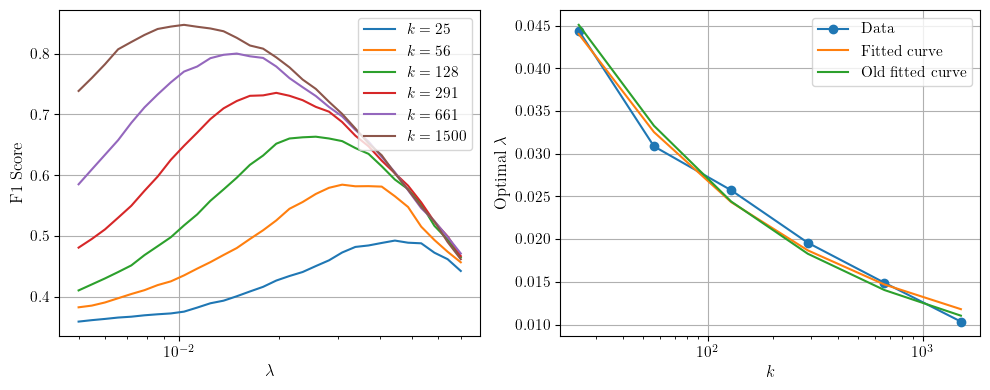

In [11]:
plot_glasso_tuning(output_results, figsize=(10, 4), old_fitted_coefs=list(config.lambda_glasso.params.values()), output_file=None)